In [264]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import glob
import json
import spacy
import multiprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [265]:
nlp = spacy.load('fr_core_news_lg')

In [266]:
# create stopwords from spacy defaults + 300 most common words in corpus

stopwords = nlp.Defaults.stop_words
stopwords = stopwords.union(set(['a', '-', '–', '_', '«', 'près', 'mêm', 'êtes', 'fût'])) # add some anomalies that skewed the model

with open('../auxiliary_lists/list_lemma.json', 'r', encoding='utf8') as f:
    frequent_words = json.load(f)
    
stopwords = stopwords.union(set([word.lower() for word in frequent_words[:300]]))

In [267]:
# separate the lemmatised texts into lists of words

data_words = []

for file in tqdm(glob.glob('../chunked_corpus_lemma_txt/*')):
    with open(file, 'r', encoding='utf8') as f:
        contents = f.read()
        data_words.append([word.lower() for word in contents.split() if word.lower() not in stopwords])

100%|███████████████████████████████████████████████████████████████████████████| 31841/31841 [03:14<00:00, 163.85it/s]


In [268]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=50) # higher threshold fewer phrases.

# join the most frequent bigrams into a single entry in the word lists
data_words_bigrams = [bigram_model[doc] for doc in tqdm(data_words)]

100%|██████████████████████████████████████████████████████████████████████████| 31841/31841 [00:15<00:00, 2065.99it/s]


In [269]:
# create id2word mapping
dictionary = gensim.corpora.Dictionary(data_words_bigrams)

# transform the bigrammed word lists into a BoW model where each word is marked by its integer representation from the dict
corpus = [dictionary.doc2bow(text) for text in tqdm(data_words_bigrams)]

100%|██████████████████████████████████████████████████████████████████████████| 31841/31841 [00:09<00:00, 3232.68it/s]


In [208]:
# train the model with 10 topics

lda_model = gensim.models.LdaMulticore(
   corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, per_word_topics=False, workers=multiprocessing.cpu_count()
)

In [209]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus=corpus, dictionary=dictionary)
vis

C:\Users\krister\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.002987 -0.002996       1        1  12.994493
8     -0.000947 -0.003179       2        1  11.209610
0     -0.002905 -0.003083       3        1  11.134926
6      0.003621  0.005202       4        1  10.852974
2      0.004489 -0.002234       5        1  10.768466
1      0.003194  0.002859       6        1  10.505883
4      0.002856  0.000027       7        1   9.967743
9     -0.003469  0.004289       8        1   9.120394
3      0.001857 -0.003848       9        1   7.825300
7     -0.005708  0.002962      10        1   5.620211, topic_info=            Term         Freq         Total Category  logprob  loglift
76861  rocambole  4691.000000   4691.000000  Default  30.0000  30.0000
941        reine  7881.000000   7881.000000  Default  29.0000  29.0000
2017         duc  6547.000000   6547.000000  Default  28.0000  28.0000
338      docteur  6652.000000   6652.000000  Default  27.0000  27.0000
4033       baron  5909.000000   5909.000000  Default  26.0000  26.0000
...          ...          ...           ...      ...      ...      ...
1154        part   500.282861   8665.770253  Topic10  -6.9128   0.0268
652        ville   527.046460  10635.426491  Topic10  -6.8607  -0.1259
2964       crier   515.478290  10014.372356  Topic10  -6.8829  -0.0879
1576       franc   501.538230   9024.444359  Topic10  -6.9103  -0.0112
143         joie   493.872672   8434.727475  Topic10  -6.9257   0.0410

[1007 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
94366      2  0.503689  -diter
659        1  0.141502   -elle
659        2  0.105255   -elle
659        3  0.092011   -elle
659        4  0.101944   -elle
...      ...       ...     ...
812        6  0.100880     œil
812        7  0.105634     œil
812        8  0.073020     œil
812        9  0.082263     œil
812       10  0.042254     œil

[5040 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 1, 7, 3, 2, 5, 10, 4, 8])

In [211]:
# test other topic numbers

topic_range = range(10,30)

coherence_scores = []
best_coherence = -1000
optimal_topics = 0
for i in topic_range:
    print(f'Building model with {i} topics')
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=i, 
                                            random_state=42,
                                            workers=multiprocessing.cpu_count(),
                                            )
    
    cm = CoherenceModel(lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence()
    coherence_scores.append(coherence)
    print(f'Model with {i} topics has coherence score of {coherence}')
    if coherence > best_coherence:
        best_coherence = coherence
        optimal_topics = i

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Building model with 10 topics


  5%|████▏                                                                              | 1/20 [01:13<23:23, 73.88s/it]

Model with 10 topics has coherence score of -1.6154243335313112
Building model with 11 topics


 10%|████████▎                                                                          | 2/20 [02:28<22:14, 74.16s/it]

Model with 11 topics has coherence score of -1.619868920393492
Building model with 12 topics


 15%|████████████▍                                                                      | 3/20 [03:42<21:03, 74.34s/it]

Model with 12 topics has coherence score of -1.6349042813797265
Building model with 13 topics


 20%|████████████████▌                                                                  | 4/20 [04:57<19:52, 74.54s/it]

Model with 13 topics has coherence score of -1.6383561515491292
Building model with 14 topics


 25%|████████████████████▊                                                              | 5/20 [06:12<18:39, 74.65s/it]

Model with 14 topics has coherence score of -1.635225956072633
Building model with 15 topics


 30%|████████████████████████▉                                                          | 6/20 [07:28<17:29, 74.97s/it]

Model with 15 topics has coherence score of -1.6422645254237127
Building model with 16 topics


 35%|█████████████████████████████                                                      | 7/20 [08:43<16:17, 75.22s/it]

Model with 16 topics has coherence score of -1.6697150958481264
Building model with 17 topics


 40%|█████████████████████████████████▏                                                 | 8/20 [09:59<15:03, 75.29s/it]

Model with 17 topics has coherence score of -1.6527901423931743
Building model with 18 topics


 45%|█████████████████████████████████████▎                                             | 9/20 [11:15<13:52, 75.69s/it]

Model with 18 topics has coherence score of -1.6483674552646304
Building model with 19 topics


 50%|█████████████████████████████████████████                                         | 10/20 [12:31<12:38, 75.83s/it]

Model with 19 topics has coherence score of -1.6854675118119484
Building model with 20 topics


 55%|█████████████████████████████████████████████                                     | 11/20 [13:48<11:25, 76.14s/it]

Model with 20 topics has coherence score of -1.6909559387576998
Building model with 21 topics


 60%|█████████████████████████████████████████████████▏                                | 12/20 [15:05<10:10, 76.34s/it]

Model with 21 topics has coherence score of -1.6615545642516178
Building model with 22 topics


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [16:23<08:57, 76.82s/it]

Model with 22 topics has coherence score of -1.6797466348387589
Building model with 23 topics


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [17:42<07:44, 77.34s/it]

Model with 23 topics has coherence score of -1.659655414272905
Building model with 24 topics


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [18:59<06:27, 77.44s/it]

Model with 24 topics has coherence score of -1.676409380858475
Building model with 25 topics


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [20:18<05:11, 77.85s/it]

Model with 25 topics has coherence score of -1.6703256640933268
Building model with 26 topics


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [21:37<03:54, 78.28s/it]

Model with 26 topics has coherence score of -1.6786690675197002
Building model with 27 topics


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [22:57<02:37, 78.83s/it]

Model with 27 topics has coherence score of -1.694271442614138
Building model with 28 topics


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [24:19<01:19, 79.63s/it]

Model with 28 topics has coherence score of -1.6775345102699026
Building model with 29 topics


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [25:43<00:00, 77.18s/it]

Model with 29 topics has coherence score of -1.6938372951433418


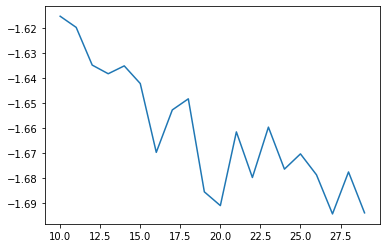

In [212]:
coherence_plot = plt.plot(topic_range, coherence_scores)
plt.show()

In [214]:
# test some more

topic_range = range(5, 10)

coherence_scores = []
best_coherence = -1000
optimal_topics = 0
for i in topic_range:
    print(f'Building model with {i} topics')
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=i, 
                                            random_state=42,
                                            workers=multiprocessing.cpu_count(),
                                            )
    
    cm = CoherenceModel(lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence = cm.get_coherence()
    coherence_scores.append(coherence)
    print(f'Model with {i} topics has coherence score of {coherence}')
    if coherence > best_coherence:
        best_coherence = coherence
        optimal_topics = i

Building model with 5 topics
Model with 5 topics has coherence score of -1.594438763991318
Building model with 6 topics
Model with 6 topics has coherence score of -1.6021501210598637
Building model with 7 topics
Model with 7 topics has coherence score of -1.595921356711012
Building model with 8 topics
Model with 8 topics has coherence score of -1.6129540183403015
Building model with 9 topics
Model with 9 topics has coherence score of -1.6133070500546038


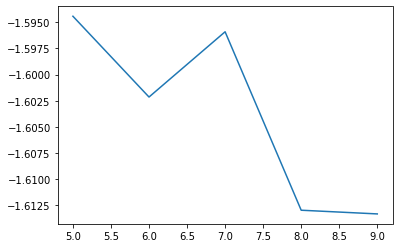

In [215]:
coherence_plot2 = plt.plot(topic_range, coherence_scores)
plt.show()

In [216]:
# not much of a difference score wise. will go with 10 topics anyways, we can revise this later if needed

final_lda_model = gensim.models.LdaMulticore(
   corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, per_word_topics=False, workers=multiprocessing.cpu_count()
)

In [276]:
# get the topic distributions for each document and turn them into a features dataframe

def create_features_csv(model, dictionary, data_words_bigrams):
    
    filenames = glob.glob('../chunked_corpus_lemma_txt/*')
    features = dict()
    
    for i, file in tqdm(enumerate(filenames)):
        file = file.split('\\')[1]
        doc_topics = model.get_document_topics(dictionary.doc2bow(data_words_bigrams[i]))
        doc_topics_w_zeros = [0]*model.num_topics
        for topic in doc_topics:
            doc_topics_w_zeros[topic[0]] = topic[1]
        features[file] = doc_topics_w_zeros
        
    df = pd.DataFrame(features).transpose()
    df.columns = [str(i) for i in range(model.num_topics)]
    
    return df

In [260]:
lda_features = create_features_csv(final_lda_model, dictionary, data_words_bigrams)

31841it [01:12, 439.64it/s]


In [261]:
lda_features

,0,1,2,3,4,5,6,7,8,9
1850_Bassanville-Anais-de_Le-Soir-et-le-matin-de-la-vie_noncanon_CHUNK_1.txt,0.057120,0.163529,0.386072,0.000000,0.073379,0.048104,0.061911,0.121472,0.087766,0.000000
1850_Bassanville-Anais-de_Le-Soir-et-le-matin-de-la-vie_noncanon_CHUNK_10.txt,0.000000,0.000000,0.163500,0.000000,0.018901,0.208412,0.140705,0.150226,0.315828,0.000000
1850_Bassanville-Anais-de_Le-Soir-et-le-matin-de-la-vie_noncanon_CHUNK_11.txt,0.324786,0.000000,0.156553,0.000000,0.000000,0.062844,0.173601,0.215678,0.060336,0.000000
1850_Bassanville-Anais-de_Le-Soir-et-le-matin-de-la-vie_noncanon_CHUNK_12.txt,0.000000,0.000000,0.210287,0.000000,0.000000,0.136521,0.403439,0.241495,0.000000,0.000000
1850_Bassanville-Anais-de_Le-Soir-et-le-matin-de-la-vie_noncanon_CHUNK_13.txt,0.516776,0.017603,0.031513,0.092473,0.000000,0.000000,0.076462,0.214907,0.041329,0.000000
...,...,...,...,...,...,...,...,...,...,...
1885_Guy-de-Maupassant_Contes-du-jour-et-de-la-nuit_canon_CHUNK_5.txt,0.632886,0.182218,0.000000,0.079542,0.000000,0.000000,0.000000,0.000000,0.039853,0.048281
1885_Guy-de-Maupassant_Contes-du-jour-et-de-la-nuit_canon_CHUNK_6.txt,0.590338,0.012221,0.000000,0.000000,0.131732,0.000000,0.000000,0.086936,0.164498,0.011197
1885_Guy-de-Maupassant_Contes-du-jour-et-de-la-nuit_canon_CHUNK_7.txt,0.176838,0.000000,0.000000,0.043777,0.210024,0.000000,0.000000,0.000000,0.567113,0.000000
1885_Guy-de-Maupassant_Contes-du-jour-et-de-la-nuit_canon_CHUNK_8.txt,0.084639,0.416780,0.000000,0.019871,0.067509,0.000000,0.000000,0.000000,0.387792,0.021665


In [262]:
lda_features.to_csv('../features/lda_features.csv', encoding='utf8', sep=',')

In [270]:
# get new table with more topics

final_lda_model_50_topics = gensim.models.LdaMulticore(
   corpus=corpus, id2word=dictionary, num_topics=50, random_state=42, per_word_topics=False, workers=multiprocessing.cpu_count()
)

In [271]:
pyLDAvis.enable_notebook()
vis_50 = gensimvis.prepare(final_lda_model_50_topics, corpus=corpus, dictionary=dictionary)
vis_50

C:\Users\krister\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18    -0.006025  0.000836       1        1  5.266229
5      0.000872 -0.003368       2        1  4.361362
39    -0.005546 -0.004138       3        1  4.214229
40    -0.004194  0.001101       4        1  3.678015
49    -0.000632  0.006452       5        1  3.506481
30     0.006519 -0.001321       6        1  3.171719
8      0.000325  0.002967       7        1  3.101700
48    -0.001625  0.004053       8        1  2.867845
34    -0.006690  0.000848       9        1  2.830397
0      0.003158  0.001062      10        1  2.794490
29     0.008902 -0.000784      11        1  2.530210
6     -0.004940  0.003518      12        1  2.406364
4     -0.006729  0.003598      13        1  2.350638
31     0.006708  0.001727      14        1  2.335255
2     -0.002345 -0.005801      15        1  2.274854
23     0.010331 -0.008735      16        1  2.270288
36     0.008687 -0.011985      17        1  2.229631
45     0.008892  0.003351      18        1  2.176509
28     0.006527 -0.004583      19        1  2.104735
1     -0.007850  0.009051      20        1  2.099153
15    -0.000316 -0.000648      21        1  2.081096
41     0.002283 -0.003076      22        1  2.053678
43    -0.000884 -0.000281      23        1  2.052046
16    -0.002014 -0.005704      24        1  1.880726
9     -0.008171 -0.000520      25        1  1.810179
27    -0.004900  0.000233      26        1  1.774652
12     0.002026  0.002402      27        1  1.761061
46    -0.006895  0.000242      28        1  1.742522
20     0.002656  0.001134      29        1  1.648123
38    -0.001073 -0.001694      30        1  1.636083
24     0.007693 -0.009834      31        1  1.534621
26    -0.009451 -0.008864      32        1  1.486218
42    -0.002009  0.004562      33        1  1.466963
10    -0.004886 -0.003545      34        1  1.458796
3      0.000424  0.002320      35        1  1.415352
17    -0.001041  0.003557      36        1  1.394270
47    -0.001557 -0.018596      37        1  1.258947
37    -0.006941 -0.007681      38        1  1.253203
11     0.004507  0.009075      39        1  1.244028
25    -0.003155  0.005254      40        1  1.226890
19    -0.002398  0.000522      41        1  1.169113
33     0.004016  0.013790      42        1  1.143732
44    -0.000694 -0.001564      43        1  1.122090
21     0.010377 -0.000775      44        1  1.087323
14    -0.007288  0.003727      45        1  0.990765
22     0.021398  0.006617      46        1  0.956052
32    -0.000616 -0.003639      47        1  0.894610
35    -0.000867  0.006531      48        1  0.688574
7     -0.005626  0.000644      49        1  0.607557
13     0.001056  0.007963      50        1  0.590630, topic_info=            Term          Freq         Total Category  logprob  loglift
1816     marquis  10841.000000  10841.000000  Default  30.0000  30.0000
941        reine   7759.000000   7759.000000  Default  29.0000  29.0000
76861  rocambole   4626.000000   4626.000000  Default  28.0000  28.0000
4061   général  10558.000000  10558.000000  Default  27.0000  27.0000
700         dame   8485.000000   8485.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
3684      écria     55.175971   7887.277550  Topic50  -6.8645   0.1693
1532     ajouter     59.636173  10720.386114  Topic50  -6.7868  -0.0599
700         dame     55.879191   8485.035687  Topic50  -6.8519   0.1089
1280     silence     55.104065   7915.047877  Topic50  -6.8658   0.1644
592       monter     55.846784   9160.298168  Topic50  -6.8524   0.0317

[4704 rows x 6 columns], token_table=        Topic      Freq       Term
term                              
90161       1  0.460979  -bourgeoi
90161       4  0.065854  -bourgeoi
90161       7  0.065854  -bourgeoi
90161       8  0.065854  -bourgeoi
90161      17  0.065854  -bourgeoi
...       ...       ...        ...
130763      7  0.26

In [277]:
lda_features_50 = create_features_csv(final_lda_model_50_topics, dictionary, data_words_bigrams)

31841it [07:17, 72.82it/s] 


In [278]:
lda_features_50.to_csv('../features/lda_features_50_topics.csv', encoding='utf8', sep=',')